In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import turbofats

## Create a lightcurve

In [2]:
n_samples = 400
n_days = 100
n_components = 7
period = 7.4
std = 0.5
time = np.random.rand(n_samples) * n_days
time.sort()
time = time.reshape(-1, 1)
cosine_components = np.random.randn(1, n_components) * np.exp(-np.linspace(0, 4, n_components))
sine_components = np.random.randn(1, n_components) * np.exp(-np.linspace(0, 4, n_components))
bias = np.random.randn(1) * 5

time_arg = 2*np.pi*time/(period/np.arange(1, n_components+1).reshape(1, n_components))
magnitude = np.sum(cosine_components * np.cos(time_arg) + sine_components * np.sin(time_arg), axis=1) + bias

error = np.ones(n_samples)*std + np.random.rand(n_samples)*std*3

magnitude += error

(400, 1) (400,)


<ErrorbarContainer object of 3 artists>

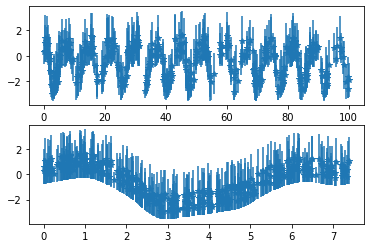

In [3]:
print(time.shape, magnitude.shape)
plt.subplot(2, 1, 1)
plt.errorbar(time, magnitude, yerr=error, fmt='*')
plt.subplot(2, 1, 2)
plt.errorbar(time % period, magnitude, yerr=error, fmt='*')

In [4]:
feature_space = turbofats.NewFeatureSpace(feature_list=['PeriodLS_v2', 'Period_fit_v2', 'Harmonics'])

In [5]:
detections_data = np.stack(
    [
        time.flatten(),
        magnitude.flatten(),
        error
    ],
    axis=-1
)
detections = pd.DataFrame(
    data=detections_data,
    columns=['mjd', 'magpsf_corr', 'sigmapsf_corr'],
    index=['asdf'] * len(detections_data)
)
feature_values = feature_space.calculate_features(detections)

2.76163


In [6]:
print(cosine_components)
print(sine_components)
print(np.sqrt(cosine_components**2 + sine_components**2))
feature_values

[[ 1.53332206e+00 -3.46816936e-01 -2.86905319e-01  5.67639226e-02
  -3.77999219e-02 -1.01550653e-03  3.86706726e-02]]
[[-0.05578493  0.23234559 -0.01994014  0.04322573  0.02133497 -0.00550677
   0.02116701]]
[[1.5343365  0.41745235 0.28759741 0.07134849 0.04340524 0.00559962
  0.04408473]]


,PeriodLS_v2,Period_fit_v2,Harmonics_mag_1,Harmonics_mag_2,Harmonics_mag_3,Harmonics_mag_4,Harmonics_mag_5,Harmonics_mag_6,Harmonics_mag_7,Harmonics_phase_2,Harmonics_phase_3,Harmonics_phase_4,Harmonics_phase_5,Harmonics_phase_6,Harmonics_phase_7,Harmonics_mse
oid,,,,,,,,,,,,,,,,
asdf,7.390982,0.000364,1.553251,0.394098,0.25982,0.102723,0.041948,0.012287,0.03747,2.577557,3.20427,1.086135,3.178153,3.756896,1.09562,0.293006


In [7]:
reconstructed_period = feature_values['PeriodLS_v2'].values[0]
reconstructed_time_arg = 2*np.pi*time/(reconstructed_period/np.arange(1, n_components+1).reshape(1, n_components))
print(reconstructed_time_arg.shape)
reconstructed_harmonics_mag = np.array([feature_values['Harmonics_mag_%d' % i].values[0] for i in range(1, 8)])
reconstructed_harmonics_phase = np.array([0.0] + [feature_values['Harmonics_phase_%d' % i].values[0] for i in range(2, 8)])

reconstructed_mag = reconstructed_harmonics_mag.reshape(1, -1)*np.cos(reconstructed_time_arg - reconstructed_harmonics_phase.reshape(1, -1))
reconstructed_mag = np.real(np.sum(reconstructed_mag, axis=1) + np.mean(magnitude))

(400, 7)


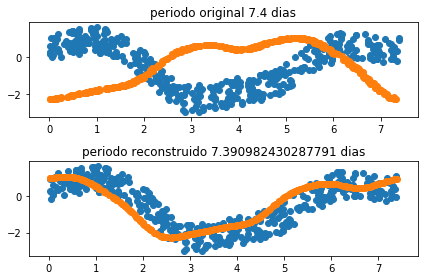

In [8]:
plt.subplot(2, 1, 1)
plt.scatter(time % period, magnitude)
plt.scatter((time - 3.0) % period, reconstructed_mag)
plt.title(f'periodo original {period} dias')
plt.subplot(2, 1, 2)
plt.scatter(time % reconstructed_period, magnitude)
plt.scatter((time-0.5) % reconstructed_period, reconstructed_mag)
plt.title(f'periodo reconstruido {reconstructed_period} dias')

plt.tight_layout()

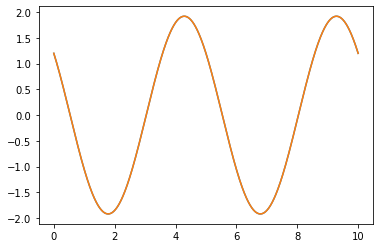

In [9]:
tt = np.linspace(0, 10, 1000)
a = 1.2
b = -1.5
f = 0.2
y = a*np.cos(2*np.pi*f*tt) + b*np.sin(2*np.pi*f*tt)
plt.plot(tt, y)
m = np.sqrt(a**2 + b**2)
phi = np.arctan2(b, a)
y2 = m*np.cos(2*np.pi*f*tt-phi)
plt.plot(tt, y2)

In [10]:
lc = pd.read_pickle('~/alerce/GP-Augmentation/results_paula/augmented_lightcurves.pkl')
lc.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/psanchez/alerce/GP-Augmentation/results_paula/augmented_lightcurves.pkl'

In [ ]:
detections = lc[lc.detected]
oids = detections.index.unique()
for oid in oids:
    one_lc = detections.loc[oid]
    feature_values = feature_space.calculate_features(one_lc)
    print(oid,)